In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline
import numpy as np
import requests


# Gathering 

In [2]:
r=requests.get('https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt')

with open('tweet_json.txt','wb') as f :
    f.write(r.content)
    f.close()

tweets = pd.read_json('tweet_json.txt',lines=True,encoding='utf-8')

tweets['created_at'] = pd.to_datetime( tweets['created_at'], errors='coerce',utc=True)
tweets.to_csv('tweett.csv',index=False)
tweets.drop(['created_at','id','full_text','truncated' ,'display_text_range','entities','extended_entities','source','in_reply_to_status_id','favorited','retweeted','possibly_sensitive','possibly_sensitive_appealable','lang','retweeted_status','quoted_status_id','quoted_status_id_str','quoted_status'],axis=1,inplace=True)
tweets.drop([ 'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status'],axis=1,inplace=True)
tweets.rename(columns={'id_str':'tweet_id'},inplace=True)
tweets.to_csv('tweet_data',index=False)

tweets = pd.read_csv('tweet_data')
tweets

,tweet_id,retweet_count,favorite_count
0,892420643555336192,8853,39467
1,892177421306343424,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822464,41,111
2350,666044226329800704,147,311
2351,666033412701032448,47,128
2352,666029285002620928,48,132


In [4]:
f = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image_predictions.tsv','wb') as d :
    d.write(f.content)
    

predictions = pd.read_csv('image_predictions.tsv',sep='\t')


# Assessment

In [5]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [6]:

predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [7]:
archieve = pd.read_csv('twitter-archive-enhanced.csv')
archieve

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [8]:
tweets.sample(10)

,tweet_id,retweet_count,favorite_count
2201,668641109086707712,573,1145
1547,689255633275777024,1212,2805
25,886983233522544640,8084,35859
330,832998151111966720,2522,14549
1052,742423170473463808,4319,10812
1404,699088579889332224,715,2451
241,846153765933735936,10226,34394
622,796031486298386432,4284,12071
126,867900495410671616,4439,24964
478,815745968457060352,4797,0


In [9]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [10]:
tweets.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [11]:
archieve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [12]:
archieve.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [13]:
archieve.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1233,712809025985978368,NaN,NaN,2016-03-24 01:11:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stubert. He just arrived. 10/10 https:...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/712809025...,10,10,Stubert,None,None,None,None
2022,672068090318987265,NaN,NaN,2015-12-02 15:01:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Gizmo. He's upset because he's no...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672068090...,7,10,Gizmo,None,None,None,None
1844,675849018447167488,6.758457e+17,4.196984e+09,2015-12-13 01:25:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog is being demoted to a 9/10 for not we...,NaN,NaN,NaN,NaN,9,10,None,None,None,None,None
129,867421006826221569,NaN,NaN,2017-05-24 16:44:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Shikha. She just watched you drop a sk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/867421006...,12,10,Shikha,None,None,None,puppo
2085,670804601705242624,NaN,NaN,2015-11-29 03:20:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Mason. He's a total frat boy. Pretends to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670804601...,10,10,Mason,None,None,None,None
395,825535076884762624,NaN,NaN,2017-01-29 02:44:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very loving and accepting puppo. Appe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825535076...,14,10,None,None,None,None,puppo
1968,673320132811366400,NaN,NaN,2015-12-06 01:56:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Frankie. He's wearing blush. 11/10 rea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673320132...,11,10,Frankie,None,None,None,None
506,812747805718642688,NaN,NaN,2016-12-24 19:52:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Sammy. At first I was like...,6.800555e+17,4.196984e+09,2015-12-24 16:00:30 +0000,https://twitter.com/dog_rates/status/680055455...,10,10,Sammy,None,None,None,None
1307,707315916783140866,NaN,NaN,2016-03-08 21:23:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Finnegus. He's trapped in a snow globe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707315916...,10,10,Finnegus,None,None,pupper,None
532,808001312164028416,NaN,NaN,2016-12-11 17:31:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He likes to stick his tongue o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808001312...,12,10,Cooper,None,None,None,None


In [14]:
archieve.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
archieve[archieve['rating_numerator'] < 10].count()[0]

440

In [16]:
archieve[archieve['rating_numerator'] < 10].tweet_id

45      883482846933004288
229     848212111729840128
315     835152434251116546
387     826598799820865537
462     817502432452313088
               ...        
2351    666049248165822465
2352    666044226329800704
2353    666033412701032449
2354    666029285002620928
2355    666020888022790149
Name: tweet_id, Length: 440, dtype: int64

In [17]:
archieve[archieve['rating_denominator'] < 10].count()[0]

3

In [18]:
archieve[archieve['rating_denominator'] < 10].tweet_id

313     835246439529840640
516     810984652412424192
2335    666287406224695296
Name: tweet_id, dtype: int64

In [19]:
archieve[archieve['rating_denominator'] > 10].count()[0]

20

In [20]:
archieve[archieve['rating_denominator'] > 10].tweet_id

342     832088576586297345
433     820690176645140481
784     775096608509886464
902     758467244762497024
1068    740373189193256964
1120    731156023742988288
1165    722974582966214656
1202    716439118184652801
1228    713900603437621249
1254    710658690886586372
1274    709198395643068416
1351    704054845121142784
1433    697463031882764288
1598    686035780142297088
1634    684225744407494656
1635    684222868335505415
1662    682962037429899265
1663    682808988178739200
1779    677716515794329600
1843    675853064436391936
Name: tweet_id, dtype: int64

In [21]:
archieve[archieve['rating_denominator'] != 10].count()[0]

23

In [22]:
archieve[archieve['rating_denominator'] != 10].tweet_id

313     835246439529840640
342     832088576586297345
433     820690176645140481
516     810984652412424192
784     775096608509886464
902     758467244762497024
1068    740373189193256964
1120    731156023742988288
1165    722974582966214656
1202    716439118184652801
1228    713900603437621249
1254    710658690886586372
1274    709198395643068416
1351    704054845121142784
1433    697463031882764288
1598    686035780142297088
1634    684225744407494656
1635    684222868335505415
1662    682962037429899265
1663    682808988178739200
1779    677716515794329600
1843    675853064436391936
2335    666287406224695296
Name: tweet_id, dtype: int64

In [23]:
archieve.name.value_counts()

None          745
a              55
Charlie        12
Lucy           11
Cooper         11
             ... 
Patch           1
Rooney          1
Chaz            1
Christoper      1
Chloe           1
Name: name, Length: 957, dtype: int64

# Assessment issues


## quality

#### 'archieve' table:

#### 'predictions table' 

#### 'tweets table'

## tidiness

# Clean

In [24]:
tweets1=tweets.copy()
predictions1=predictions.copy()
archieve1=archieve.copy()
archieve1.columns


Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

# Tidiness

# Define

 merge dog stages 4 columns into one dog_stage column

# Code

In [25]:
archieve1['dog_stage']=archieve1['text'].str.extract('(doggo|floofer|pupper|puppo)')
archieve1.drop(['doggo','floofer','pupper','puppo'],axis=1,inplace=True)


# Test

In [26]:
archieve1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  dog_stage                   399 n

# Define

merge all dataframes into one based on tweet_id

In [27]:
archieve1 = pd.merge(archieve1,tweets1,on='tweet_id',how='left')
archieve1 = pd.merge(archieve1,predictions1,on='tweet_id',how='left')

# Test

In [28]:
archieve1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  dog_stage                   399 n

# Quality

# Define

 there are 181 retweets as indicated by retweeted_status_id , so we need to delete rows that represent retweets and all related columns

# Code

In [29]:
archieve1=archieve1[archieve1.retweeted_status_id.isnull()]
archieve1=archieve1.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)


# Test

In [30]:
archieve1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  dog_stage              364 non-null    object 
 11  retweet_count          1420 non-null   float64
 12  favorite_count         1420 non-null   float64
 13  jpg_url                1994 non-null   object 
 14  img_num                1994 non-null   float64
 15  p1  

# Define

convert invalid names to NaN then fill into these NaN values correct names that extracted from column text after 'named'

# Code

In [31]:
archieve1.name = archieve1.name.replace(regex=['^[a-z]+','None'],value=np.nan)
sum(archieve1.name.isnull())

784

In [32]:
def func(text):
    txt_l=text.split()
    for word in txt_l :
        if word.lower() == 'named' :
            name_index=txt_l.index(word)+1
            return txt_l[name_index]
        else :
            pass
    return np.nan

In [33]:
archieve1.name=np.where(archieve1.name.isnull(),archieve1.text.apply(func),archieve1.name)

# Test

In [34]:
sum(archieve1.name.isnull())

761

# Define

convert tweet_id type to string


# Code

In [35]:
archieve1.tweet_id=archieve1.tweet_id.astype(str)

# Test

In [36]:
archieve1.tweet_id.describe()

count                   2175
unique                  2175
top       707983188426153984
freq                       1
Name: tweet_id, dtype: object

# Define

change timestamp dtype to datetime 

# Code

In [37]:
archieve1.timestamp=pd.to_datetime(archieve1.timestamp)

# Test

In [38]:
archieve1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   1414 non-null   object             
 10  dog_stage              364 non-null    object             
 11  retweet_count          1420 non-null   float64          

# Define

delete rows with missing photos


# Code

In [39]:
archieve1=archieve1[archieve1.jpg_url.notnull()]

# Test

In [40]:
archieve1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   object             
 1   in_reply_to_status_id  23 non-null     float64            
 2   in_reply_to_user_id    23 non-null     float64            
 3   timestamp              1994 non-null   datetime64[ns, UTC]
 4   source                 1994 non-null   object             
 5   text                   1994 non-null   object             
 6   expanded_urls          1994 non-null   object             
 7   rating_numerator       1994 non-null   int64              
 8   rating_denominator     1994 non-null   int64              
 9   name                   1373 non-null   object             
 10  dog_stage              326 non-null    object             
 11  retweet_count          1300 non-null   float64          

# Define

need to replace '_' in P-columns to ' '

# Code

In [41]:
archieve1.p1=archieve1.p1.str.replace('_',' ')
archieve1.p2=archieve1.p2.str.replace('_',' ')
archieve1.p3=archieve1.p3.str.replace('_',' ')


# Test

In [42]:
archieve1.p1.head()

0         orange
1      Chihuahua
2      Chihuahua
3    paper towel
4         basset
Name: p1, dtype: object

In [43]:
archieve1.p2.head()

0                 bagel
1              Pekinese
2              malamute
3    Labrador retriever
4      English springer
Name: p2, dtype: object

In [44]:
archieve1.p3.head()
archieve1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   object             
 1   in_reply_to_status_id  23 non-null     float64            
 2   in_reply_to_user_id    23 non-null     float64            
 3   timestamp              1994 non-null   datetime64[ns, UTC]
 4   source                 1994 non-null   object             
 5   text                   1994 non-null   object             
 6   expanded_urls          1994 non-null   object             
 7   rating_numerator       1994 non-null   int64              
 8   rating_denominator     1994 non-null   int64              
 9   name                   1373 non-null   object             
 10  dog_stage              326 non-null    object             
 11  retweet_count          1300 non-null   float64          

# Define

delete rows without retweet_count entries

# Code

In [45]:
archieve1=archieve1[archieve1.retweet_count.notnull()]

# Test

In [46]:
sum(archieve1.retweet_count.isnull())

0

In [47]:
 archieve1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 2 to 2354
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1300 non-null   object             
 1   in_reply_to_status_id  15 non-null     float64            
 2   in_reply_to_user_id    15 non-null     float64            
 3   timestamp              1300 non-null   datetime64[ns, UTC]
 4   source                 1300 non-null   object             
 5   text                   1300 non-null   object             
 6   expanded_urls          1300 non-null   object             
 7   rating_numerator       1300 non-null   int64              
 8   rating_denominator     1300 non-null   int64              
 9   name                   878 non-null    object             
 10  dog_stage              209 non-null    object             
 11  retweet_count          1300 non-null   float64          

In [48]:
archieve1.to_csv('twitter_archive_master.csv',index=False)
df = pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1300 non-null   int64  
 1   in_reply_to_status_id  15 non-null     float64
 2   in_reply_to_user_id    15 non-null     float64
 3   timestamp              1300 non-null   object 
 4   source                 1300 non-null   object 
 5   text                   1300 non-null   object 
 6   expanded_urls          1300 non-null   object 
 7   rating_numerator       1300 non-null   int64  
 8   rating_denominator     1300 non-null   int64  
 9   name                   878 non-null    object 
 10  dog_stage              209 non-null    object 
 11  retweet_count          1300 non-null   float64
 12  favorite_count         1300 non-null   float64
 13  jpg_url                1300 non-null   object 
 14  img_num                1300 non-null   float64
 15  p1  

# Data Analysis and Visualization 

## comparizon of different dog stages

In [49]:
stage_df=df.dog_stage.value_counts()
stage_df

pupper    151
doggo      38
puppo      20
Name: dog_stage, dtype: int64

Text(0.5, 1.0, 'percentages of dog stages')

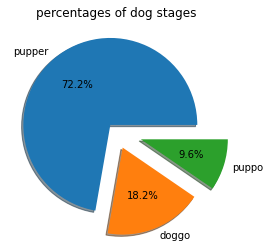

In [50]:
plt.pie(stage_df,labels=['pupper','doggo','puppo'],
       autopct='%1.1f%%',
       shadow= True
       ,explode=(0.1,0.2,0.3))
plt.title('percentages of dog stages')

## Dicovering relationship between (retweet count and favorite count)

Text(0.5, 1.0, 'relationship between retweet count and favourite count')

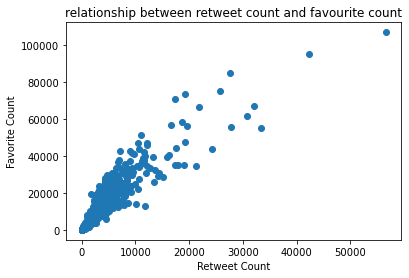

In [51]:
plt.scatter(df.retweet_count,df.favorite_count)
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.title('relationship between retweet count and favourite count')

In [52]:
df=df.drop(['in_reply_to_user_id','in_reply_to_status_id'],axis=1)

## comparing stages of dogs to people's favorite count and retweet count

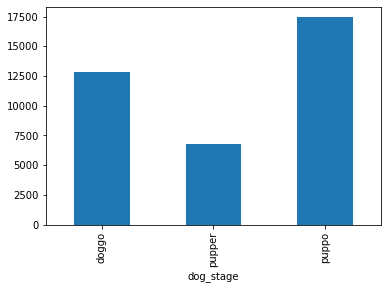

In [53]:
x = df.groupby('dog_stage')['favorite_count'].mean().plot(kind='bar')




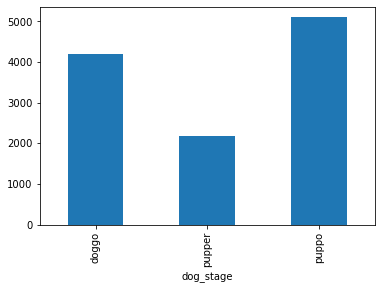

In [54]:
y = df.groupby('dog_stage')['retweet_count'].mean().plot(kind='bar')

In [72]:
df.p1.value_counts()

golden retriever      95
Pembroke              65
Labrador retriever    62
Chihuahua             45
pug                   39
                      ..
hyena                  1
jellyfish              1
microphone             1
Egyptian cat           1
terrapin               1
Name: p1, Length: 300, dtype: int64


# Detecting most common times(for example : month)of WeRateDog blog user interacting

In [60]:
import datetime as dt
df['timestamp']=pd.to_datetime(df['timestamp'])
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
print('the most common month :{}'.format(df.month.max()))
print('the most common year :{}'.format(df.year.max()))

the most common month :12
the most common year :2017


# Experimenting neural network species classification accuracy

In [66]:
xx = df.p1_dog[df.p1_dog == True].count()/df.p1_dog.count()
print('Neural network species specification accuracy : {}'.format(xx))

Neural network species specification accuracy : 0.7376923076923076


# Detecting features (like : dog_stage, dog_species) of dogs of best rating 

In [71]:
df.rating_numerator.max()
df.loc[df.rating_numerator == 1776,'p1']

452    bow tie
Name: p1, dtype: object

# Wrangling data

Wrangling data means getting ready valid accurate consistent tidy data for analysis, prediction modeling or
 for machine learning models, that can be achieved through two essential stages of assessment and cleaning . so,
    i think it needs data detective skills for investigation as explained below :

Wrangling challenges i have faced in this project can be summarized under:
   - Gathering data from CSV file, TSV file and Json file that is collected using tweepy API library for tweeter 
    to collect extra data about WeRateDogs tweets that shall impact our analysis.
   - Then assessing data by investigating it visually through Microsoft office or google spreadsheets and 
    programmatically using pandas library or visually using matplotlib (Using clean tidy data criteria).
   - Finally cleaning assessment issues programmaticaly to purify and enhance data that will be used later in analysis.
clean criteria: is about to ensure valid accurate consistent not null values
tidy  criteria: is to ensure that each column is a variable and each row is a observation or record and each table is 
    a observational unit.

### Let's start investigating